In [1]:
!pip install numpy==2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.0 which is incompatible.


In [1]:
!pip install gensim

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

from google.colab import files
uploaded = files.upload()

Saving Scraping.json to Scraping.json


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import wandb  # будем использовать для логирования
import re
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

wandb.login()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: theotheo46 (theotheo46-trs) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


device(type='cpu')

In [ ]:
!wandb login cc603ae0565bbbfce5cc5b068a9bddabb8950920

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
data_train = pd.read_csv('data/train.csv', sep=',')
data_test = pd.read_csv('data/test.csv', sep=',')

# Выделяем целевые переменные
labels_train = data_train['label']
labels_test = data_test['label']

# Смотрим на размер данных
len(data_train), len(data_test)
# Output:
# (120000, 7600)


(120000, 7600)

In [ ]:
data_train['text'][:5]

0    Wall St. Bears Claw Back Into the Black (Reute...
1    Carlyle Looks Toward Commercial Aerospace (Reu...
2    Oil and Economy Cloud Stocks' Outlook (Reuters...
3    Iraq Halts Oil Exports from Main Southern Pipe...
4    Oil prices soar to all-time record, posing new...
Name: text, dtype: object

In [ ]:
def tokenize(text):
    reg = re.compile(r'\w+')
    return reg.findall(text)

# Применяем функцию токенизации текстов к тренировочной и тестовой выборкам
data_tok_train = [tokenize(t.lower()) for t in data_train['text']]
data_tok_test = [tokenize(t.lower()) for t in data_test['text']]

In [ ]:
stop_words = stopwords.words('english')

def remove_stopwords(tokenized_texts):
    clear_texts = []
    for words in tokenized_texts:
        clear_texts.append([word for word in words if word not in stop_words])

    return clear_texts


In [ ]:
data_tok_train = remove_stopwords(data_tok_train)
data_tok_test = remove_stopwords(data_tok_test)


In [ ]:
def lemmatize_text(tokenized_texts):
    lemmatized_data = []
    lemmatizer = WordNetLemmatizer()
    for words in tqdm(tokenized_texts):
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        lemmatized_data.append(lemmatized_words)
    return lemmatized_data


lemmatized_train = lemmatize_text(data_tok_train)
lemmatized_test = lemmatize_text(data_tok_test)


  0%|          | 0/120000 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
w2v_model = Word2Vec(
    lemmatized_train,
    vector_size=100,
    min_count=4,
    window=5
).wv


In [ ]:
w2v_model.get_vector('word')

array([-0.35229364, -0.28613487,  0.84874773, -0.88647336,  0.667387  ,
       -0.14061968, -0.01737839,  1.4909592 , -0.00771039,  0.24994071,
       -1.8264297 , -0.15398373, -0.4901986 , -0.05590612, -0.7811263 ,
       -0.0653145 , -0.14628246,  0.27856007,  1.6799984 , -0.4447753 ,
        0.60498357,  0.22106847,  0.64900684,  0.486832  , -0.63211846,
        1.1653243 , -0.33075592, -0.01126555,  0.89076424,  1.9020722 ,
       -0.17842266,  0.20437464,  0.5035975 , -0.3293477 ,  0.44938287,
       -0.2260476 ,  0.0100739 ,  0.99903256, -0.27758387,  0.01884967,
        0.45393792,  0.35218117,  0.07084449, -0.7445908 ,  0.75876284,
       -0.41674593,  0.23770867,  0.5613349 , -0.08249725,  0.49912533,
        0.09932999,  1.0813301 ,  0.39050052,  0.47824636, -0.92539513,
       -0.05390639,  0.17725924,  0.15128887, -0.21435738,  0.5724732 ,
       -1.4903504 , -1.2104806 ,  1.8208798 ,  0.84873897, -0.19134171,
       -0.93908894,  0.5832773 ,  0.0710884 , -0.5020134 ,  0.74

In [ ]:
def encode_dataset(dataset):
    encoded = []

    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))

    return encoded


In [ ]:
train_embeddings = encode_dataset(lemmatized_train)
test_embeddings = encode_dataset(lemmatized_test)

Text(0, 0.5, 'Count')

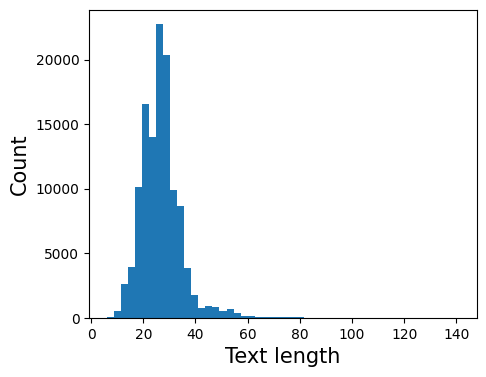

In [ ]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=50);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15)


In [ ]:
train_dataset = list(zip(train_embeddings, labels_train))
test_dataset = list(zip(test_embeddings, labels_test))

In [ ]:
def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)


In [ ]:
w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

batch = next(iter(w2v_test_loader))
batch


(tensor([[[-3.3838e-01, -9.9892e-01, -8.7270e-01,  ...,  1.2466e+00,
           -3.3864e-02,  2.7508e+00],
          [ 2.6088e+00,  4.7691e-02, -5.0086e-01,  ...,  1.1848e+00,
            1.2159e+00, -3.6392e+00],
          [-1.6324e+00, -3.2776e-01, -1.3693e+00,  ...,  5.7285e-02,
            1.1416e+00, -9.6249e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[-5.1029e-01,  1.4889e+00,  7.0259e-01,  ..., -2.4097e+00,
           -3.0551e+00,  6.6585e-01],
          [-4.1358e-02,  2.8291e+00, -5.9502e-01,  ..., -2.7954e+00,
           -1.4224e+00, -9.7065e-01],
          [-7.4231e-01,  1.5922e+00, -1.3230e+00,  ...,  1.9883e-01,
           -2.9116e-01,  9.4280e-01],
          ...,
    

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()

        # не меняем число каналов
        self.conv1 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)

        self.fc = nn.Linear(hid_dim, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)

        x = self.fc(x)
        return x

In [ ]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """

    # не забываем переводить в train режим
    model.train()
    criterion = nn.CrossEntropyLoss()

    # сэмплируем из dataloader наши объекты и целевые переменные
    for i, (tokens, labels) in enumerate(dataloader):
		    # перемещаем на device
        tokens = tokens.to(device)
        labels = labels.to(device)

        # прогоняем через модель
        logits = model(tokens)
        # считаем ошибку
        loss = criterion(logits, labels)

        # делаем шаг оптимизации
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # логируем значения ошибки и точности
        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": (logits.argmax(-1) == labels).float().mean().item()
        })

In [ ]:
@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """

    # не забываем переводить в eval режим
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)

    # логируем тестовые значения ошибки и точности
    wandb.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

    return accuracy, mean_loss

In [ ]:
# инициализируем модель и переводим на GPU, если есть
model = SimpleCNN().to(device)

# используем Adam для обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [ ]:
wandb.init(project="nlp_lesson2", name="simple_cnn")

# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_accuracy,▁▄▄██
test_loss,█▅▄▂▁
train_accuracy,▅▆▆▄▃▆▆▇▂▁█▆▃▅▇▅▂█▄▁▇▆█▅▃▄▄▄▃▇▅▆▅▅▅▆▂▆▇▂
train_loss,█▆▄▃▅▂▄▄▃▄▄▃▃▄▃▄▃▅▃▅▁▁▄▃▂▅▂▆▃▂▂▃▃▂▅▅▃▃▂▂
test_accuracy,0.89934
test_loss,0.29368
train_accuracy,0.9375
train_loss,0.22889


In [ ]:
print('SimpleCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

SimpleCNN
Test accuracy: 0.8993421
Test loss: 0.29367655711444585


In [ ]:
class TextCNN(nn.Module):
    def __init__(self, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__()

        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, n_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)

        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [ ]:
# инициализируем модель и переводим на GPU, если есть
model = TextCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

wandb.init(project="nlp_lesson2", name="textcnn")

# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_accuracy,▁▆▆██
test_loss,█▅▃▁▁
train_accuracy,▄▆▅▅▆▅▁▅▇▄▅▂▄▆▂█▇▄█▆▅▇▅▆▅▆▂▃▆▇▆▆▃▄▆▄▇▆▅▄
train_loss,▄▃▄▄▁▂▅█▃▂▆▅▂▄▆▂▃▂▁▃▃▂▂▄▆▆▅▃▅█▄▃▁▁▄▁▂▃▁▄
test_accuracy,0.90013
test_loss,0.2896
train_accuracy,0.96875
train_loss,0.12176


In [ ]:
print('TextCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

# Output:
# TextCNN
# Test accuracy: 0.89842105
# Test loss: 0.29107235357949607

TextCNN
Test accuracy: 0.9001316
Test loss: 0.2895990421083805


In [ ]:
# берем словарь из word2vec, чтобы он точно не изменился
vocabulary = w2v_model.index_to_key

In [ ]:
# будем использовать для конвертации слов в индексы
word2id = {word: i for i, word in enumerate(vocabulary)}
word2id['[PAD]'] = len(word2id)

In [ ]:
def text2ids(texts):
    # конвертируем все тексты в наборы индексов
    ids = []
    for words in texts:
        ids.append(torch.tensor([word2id[word] for word in words if word in word2id]))

    return ids

In [ ]:
train_ids = text2ids(lemmatized_train)
test_ids = text2ids(lemmatized_test)

train_dataset = list(zip(train_ids, labels_train))
test_dataset = list(zip(test_ids, labels_test))

In [ ]:
def collate_fn(batch):
    # та же самая функция обработки батча
    # только теперь мы имеем дело с индексами, поэтому паддим индексом специального символа
    ids, labels = zip(*batch)
    return (
        pad_sequence(ids, padding_value=word2id['[PAD]']).permute(1, 0),
        torch.tensor(labels)
    )

In [ ]:
from torch.utils.data import DataLoader

ids_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
ids_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

batch = next(iter(ids_train_loader))[0]

In [ ]:
class EmbeddingTextCNN(TextCNN):
    def __init__(self, vocab_size, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__(hid_dim, kernel_sizes, n_classes)

        self.embedding = nn.Embedding(vocab_size, hid_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = super().forward(x)
        return x

In [ ]:
# инициализируем модель и переводим на GPU, если есть
model = EmbeddingTextCNN(vocab_size=len(word2id)).to(device)

# ставим скорость обучения в 2 раза больше, потому что иначе эмбеддинги будут долго учиться
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

wandb.init(project="nlp_lesson2", name="textcnn_train_embeddings")

# учим в течение 10 эпох, так как помимо модели нужно обучить слой эмбеддингов
for epoch in range(10):
    train(model, ids_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, ids_test_loader)

wandb.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_accuracy,▁▃▅▆▇█████
test_loss,█▆▄▂▂▁▁▁▁▁
train_accuracy,▁▁▃▆▆▃▅▆▄▆▅▅█▇▆▅▆▇▆▇▆▇▅▇▄▆▆▇▆▇▇▆▆▇▆▆▆▇▇▇
train_loss,█▆▅▄▃▃▃▂▃▂▂▁▁▂▂▂▄▅▂▂▂▃▂▂▃▂▂▁▃▂▃▂▂▃▂▃▂▁▂▂
test_accuracy,0.91342
test_loss,0.26751
train_accuracy,1
train_loss,0.0962


In [ ]:
print('TextCNN train embeddings')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

# Output:
# TextCNN train embeddings
# Test accuracy: 0.9123684
# Test loss: 0.26905588619509024


TextCNN train embeddings
Test accuracy: 0.91342103
Test loss: 0.267505191942971


In [ ]:
@torch.no_grad()
def explain(model, tokens, label):
    model.eval()
    token_ids = torch.cat(text2ids([tokens])).unsqueeze(0)

    baseline_pred = model(token_ids.to(device)).cpu()
    baseline_prob = torch.softmax(baseline_pred, dim=-1)[0, label]

    drop_one_batch = []
    for t in range(len(token_ids[0])):
        drop_one_token_ids = torch.hstack([token_ids[:, :t], token_ids[:, t+1:]])
        drop_one_batch.append(drop_one_token_ids)

    drop_one_batch = torch.cat(drop_one_batch)

    drop_one_pred = model(drop_one_batch.to(device)).cpu()
    drop_one_prob = torch.softmax(drop_one_pred, dim=-1)[:, label]

    diffs = baseline_prob - drop_one_prob

    return list(zip(tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]

    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

In [ ]:
i = 0
print(label_names[labels_train[i]])

tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])

draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


wall st bear claw back black reuters reuters short seller wall street dwindling band ultra cynic seeing green

In [ ]:
i = 42
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


technology company sue five ex employee marlborough based technology company suing five former employee including three senior manager allegedly conspiring employer working opening competing business

In [ ]:
i = 1000
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sci/Tech


european union extends microsoft time warner review brussels belgium ap european antitrust regulator said monday extended review deal microsoft corp msft time warner inc

In [ ]:
i = 1023
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, lemmatized_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sports


olympics thorpe beat phelps u suffers gold gap athens reuters australian swimmer ian thorpe beat arch rival michael phelps men 200 meter freestyle monday united state trailed china australia japan medal table day three olympic game